In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm

In [13]:
# Dataset
def load_mnist(batch_size=32, train=True):

    to_tensor_transform = torchvision.transforms.ToTensor()
    dataset = torchvision.datasets.MNIST(root = "./data", train= train, download=True, transform= to_tensor_transform)
    dataloader = DataLoader(dataset = dataset , batch_size = batch_size)

    return dataset, dataloader

In [14]:
def plot_image_and_label(image, label):
    plt.imshow(image)
    if type(label) is not int:
        _,predicted = torch.max(label,1)
        plt.title("Best label = " + str(predicted.item()) + ", with Score: " + str(round(label[0][predicted].item() * 100,2)))
    else:
        plt.title("Label = " + str(label))
    plt.show()
    return

100%|██████████| 9912422/9912422 [00:00<00:00, 37728977.85it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 43047510.24it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 19713503.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 10566017.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



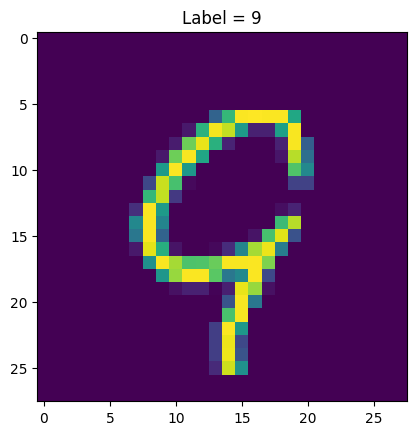

In [15]:
train_dataset, train_dataloader = load_mnist(batch_size=1, train=True)
ex_image, ex_label = train_dataset[random.randint(0,1000)]
plot_image_and_label(ex_image.reshape(28,28), ex_label)

In [29]:
class MyMLP(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(MyMLP, self).__init__()

        self.input_size = input_size
        self.lin1 = nn.Linear(input_size, 128)
        self.lin2 = nn.Linear(128, 256)
        self.lin3 = nn.Linear(256, output_size)
        self.relu = nn.ReLU()


    def forward(self, x):

        x = x.view(-1, self.input_size) 
        out = self.lin1(x)
        out = self.relu(out)
        out = self.lin2(out)
        out = self.relu(out)
        out = self.lin3(out)
        return out

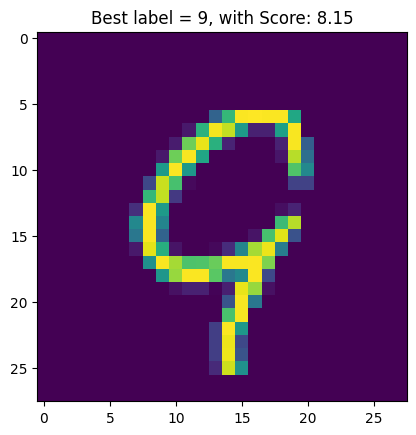

In [30]:
test_model = MyMLP(784, 10)
test_output = test_model(ex_image.flatten()) # Notice how we flatten the 2d image into 1d to use the MLP

plot_image_and_label(ex_image.reshape(28,28), test_output)

In [31]:
model = MyMLP(784, 10)                                
loss_function = nn.CrossEntropyLoss()                        
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)                

print("BEFORE GRADIENT STEP:")
ex_pred = model(ex_image.flatten())
print("prediction:",ex_pred)
ex_label = torch.Tensor([1]).long()
print("label:",ex_label)

optimizer.zero_grad() 

ex_loss1 = loss_function(ex_pred, ex_label)
print("loss",ex_loss1.item())

ex_loss1.backward() 

print()
print("AFTER GRADIENT STEP:")
optimizer.step() 

ex_pred = model(ex_image.flatten())
print("prediction:",ex_pred)
ex_label = torch.Tensor([1]).long()
print("label:",ex_label)

ex_loss2 = loss_function(ex_pred, ex_label)
print("loss",ex_loss2.item())
print("Difference in loss:", (ex_loss1 - ex_loss2).item())
print("This should be some positive number to say we reduced loss")

BEFORE GRADIENT STEP:
prediction: tensor([[-0.0352, -0.0626,  0.0362,  0.0107,  0.0664,  0.0004, -0.0306,  0.1105,
         -0.0569, -0.0161]], grad_fn=<AddmmBackward0>)
label: tensor([1])
loss 2.368889331817627

AFTER GRADIENT STEP:
prediction: tensor([[-0.0364, -0.0303,  0.0369,  0.0076,  0.0581, -0.0052, -0.0334,  0.1046,
         -0.0604, -0.0197]], grad_fn=<AddmmBackward0>)
label: tensor([1])
loss 2.336245536804199
Difference in loss: 0.032643795013427734
This should be some positive number to say we reduced loss


In [32]:
def training(model, loss_function, optimizer, train_dataloader, n_epochs, update_interval):
    losses = []
    for n in range(n_epochs):
        for i, (image, label) in enumerate(tqdm(iter(train_dataloader))):
            optimizer.zero_grad()
            pred = model(image)
            loss = loss_function(pred, label)
            loss.backward()
            optimizer.step()
            if i % update_interval == 0:
                losses.append(round(loss.item(), 2)) # This will append your losses for pl
    return model, losses

100%|██████████| 938/938 [00:07<00:00, 131.90it/s]


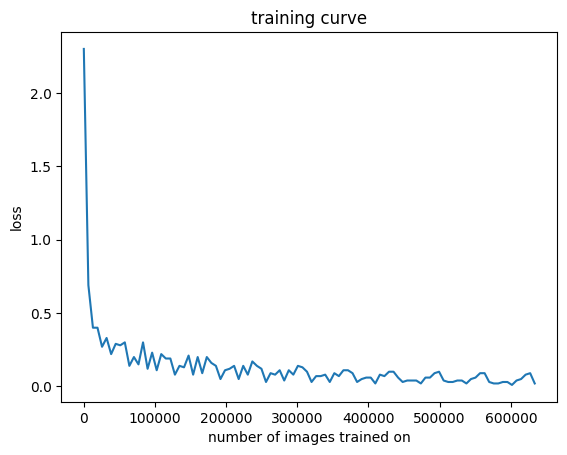

In [42]:
lr = 0.10  
batch_size = 64     
update_interval = 100   
n_epochs = 10           

train_dataset, train_dataloader = load_mnist(batch_size=batch_size, train=True)

model = MyMLP(784, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses)
plt.title("training curve")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

In [43]:
def testing(model, loss_function, test_data):
    sum_loss = 0
    n_correct = 0
    total = 0
    for i, (image, label) in enumerate(tqdm(iter(test_data))):
    
        pred = model(image)
        loss = loss_function(pred, label)
        sum_loss += loss.item()
        _, predicted = torch.max(pred,1)
        n_correct += (predicted == label).sum()
        total += label.size(0)
    test_acc = round(((n_correct / total).item() * 100), 2)
    avg_loss = round(sum_loss / len(test_data), 2)
    print("test accuracy:", test_acc)
    print("test loss:", avg_loss )
    return test_acc, avg_loss

print("testing the previously trained model on test dataset of MNIST")
test_dataset, test_dataloader = load_mnist(batch_size=10000, train=False)
_,_= testing(trained_model, loss_function, test_dataloader)

testing the previously trained model on test dataset of MNIST


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

test accuracy: 97.56
test loss: 0.08


In [44]:
def train_and_test(model, loss_function, optimizer, batch_size, update_interval, n_epochs):

    _, train_dataloader = load_mnist(batch_size=batch_size, train=True)
    trained_model, losses = training(model, loss_function, optimizer, train_dataloader, n_epochs=n_epochs, update_interval=update_interval)

    _, test_dataloader = load_mnist(batch_size=10000, train=False)
    test_acc, test_loss = testing(trained_model, loss_function, test_dataloader)

    plt.plot(np.arange(len(losses)) * batch_size * update_interval, losses, color="b", label="train loss")
    plt.hlines(test_loss, 0, len(losses) * batch_size * update_interval, color='r', label="test loss")
    plt.legend()
    plt.title("training curve")
    plt.xlabel("number of images trained on")
    plt.ylabel("loss")
    plt.show()

    return trained_model, test_loss

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

test accuracy: 97.61
test loss: 0.08


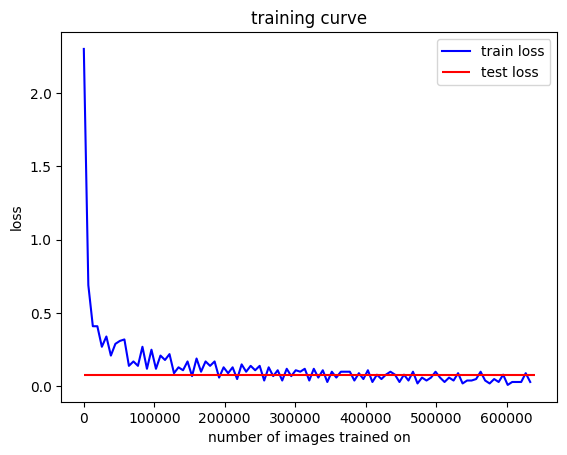

In [45]:
lr = 0.10             
batch_size = 64     
update_interval = 100   
n_epochs = 10           

model = MyMLP(784, 10)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

_, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)

In [46]:
class MyCNN(nn.Module):
    
    def __init__(self, input_size, output_size):
        super(MyCNN, self).__init__()

        self.input_size = input_size 
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 3, kernel_size= 4, stride=1)
        self.conv2 = nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size= 4, stride=1)

        self.relu = nn.ReLU()      
        
        output1 = (28 - 4)//1 + 1
        output2 = (output1 - 4)//1 + 1

        cnn_out_size = 5 * (output2 * output2)                        

        self.mlp = MyMLP(cnn_out_size, output_size)


    def forward(self, x):

        x = x.view(-1, 1, 28, 28) 
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.relu(out)
        self.filtered = out  
        out = out.flatten()  
        out = self.mlp(out)  

        return out 

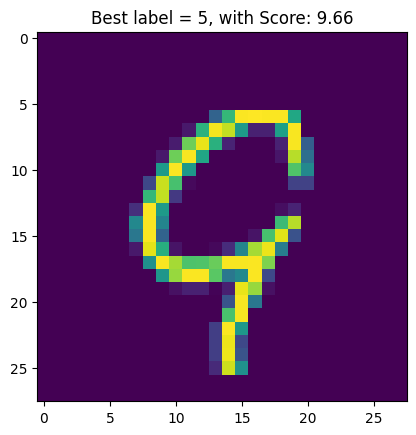

In [47]:
test_model = MyCNN(784, 10)
test_output = test_model(ex_image)
plot_image_and_label(ex_image.reshape(28,28), test_output)

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]


test accuracy: 98.45
test loss: 0.07


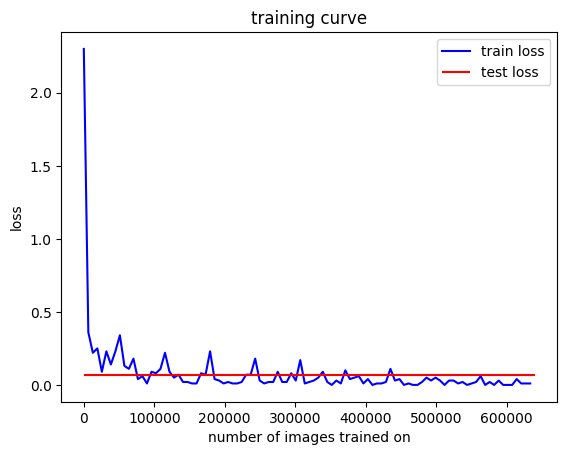

In [51]:
lr = 0.001             
batch_size = 64       
update_interval = 100   
n_epochs = 10            

model = MyCNN(784, 10)                                          
loss_function = nn.CrossEntropyLoss()                           
optimizer = torch.optim.Adam(model.parameters(), lr=lr)      

trained_model, _ = train_and_test(model, loss_function, optimizer, batch_size=batch_size, update_interval=update_interval, n_epochs=n_epochs)

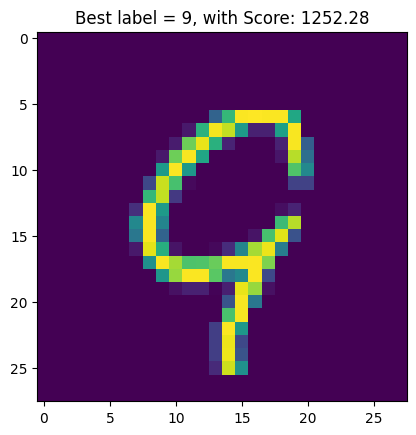

In [52]:
test_output = trained_model(ex_image)

plot_image_and_label(ex_image.reshape(28,28), test_output)

In [53]:
def display_filters(params, name):
    fig = plt.figure(figsize=(10, 7)) 
    rows = len(params)//5 + 1

    for i,filter in enumerate(params):
        fig.add_subplot(rows, 5, i+1)
        plt.imshow(filter)
        plt.axis('off')
        plt.title(name + "filter #"+str(i))
    
    plt.show

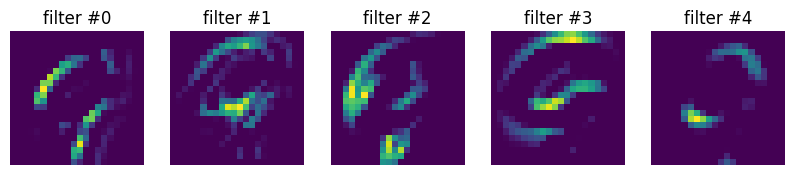

In [54]:
filtered = model.filtered[0].detach().numpy()
display_filters(filtered, "")

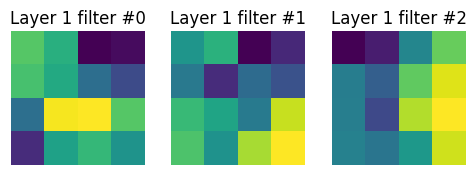

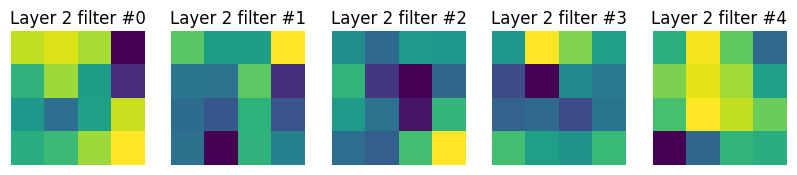

In [55]:
params = model.parameters()
conv1_params = next(params)[:,0,:,:].detach().numpy()
relu = next(params)
conv2_params = next(params)[:,0,:,:].detach().numpy() 

display_filters(conv1_params, "Layer 1 ")

display_filters(conv2_params, "Layer 2 ")